# Generative Pre-Training from Molecules

In this notebook, we demonstrate how to pretrain
[HuggingFace](https://huggingface.co/transformers/)
[GPT-2](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2lmheadmodel) language model 
on a SMILES corpus. [SMILES](https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html) is
a language construct for representing molecules, with its unique syntax and vocabulary of 
molecular constituents. Pretraining GPT-2 on large and diverse corpora allows capturing
general representations of molecules capable of being transferred to such downstream tasks as
molecular-property prediction and low-data de novo molecular design.

---

*Author: Sanjar Adilov* <br/>
*Paper: [Generative Pre-Training from Molecules](https://doi.org/10.33774/chemrxiv-2021-5fwjd)*,
*DOI: 10.33774/chemrxiv-2021-5fwjd* <br/>
*Package: https://github.com/sanjaradylov/smiles-gpt*

## Main Package

Our [`smiles_gpt`](https://github.com/sanjaradylov/smiles-gpt/tree/master/smiles_gpt)
package implements
[pytorch-lightning](https://www.pytorchlightning.ai/)-compatible modules for data loading,
model training and testing. The SMILES tokenizer and downstream regression and
single-/multi-output classification models are also compatible with HuggingFace API.

In [1]:
try:
    import smiles_gpt as gpt
except ImportError:
    import sys
    sys.path.extend([".."])  # Parent directory stores `smiles_gpt` package.
    import smiles_gpt as gpt

For demonstration purposes, we use only 10K subset of PubChem data made available by
[ChemBERTa](https://arxiv.org/abs/2010.09885) developers. The original model was pretrained
on the first 5M compounds with the following hyperparameters:
```python
hyperparams = {"batch_size": 128, "max_epochs": 2, "max_length": 512,
               "learning_rate": 5e-4, "weight_decay": 0.0,
               "adam_eps": 1e-8, "adam_betas": (0.9, 0.999),
               "scheduler_T_max": 150_000, "final_learning_rate": 5e-8,
               "vocab_size": 1_000, "min_frequency": 2, "top_p": 0.96,
               "n_layer": 4, "n_head": 8, "n_embd": 512}
```

In [2]:
# 10K subset of PubChem SMILES dataset.
filename = "../data/pubchem-10m.txt"
# Directory to serialize a tokenizer and model.
checkpoint = "../checkpoints/benchmark-10m"
tokenizer_filename = f"{checkpoint}/tokenizer/tokenizer.json"

# Tokenizer, model, optimizer, scheduler, and trainer hyperparameters.
hyperparams = {"batch_size": 256, "max_epochs": 30, "min_epochs": 15,
               "max_length": 512, "learning_rate": 5e-4, "weight_decay": 0.0,
               "adam_eps": 1e-8, "adam_betas": (0.9, 0.999),
               "scheduler_T_max": 150_000, "final_learning_rate": 5e-8,
               "vocab_size": 1_000, "min_frequency": 2, "top_p": 0.96,
               "n_layer": 6, "n_head": 12, "n_embd": 12 * 48}

gpus = 4  # Specify either a list of GPU devices or an integer (0 for no GPU).
num_workers = 32  # Number of dataloader worker processes.
is_tokenizer_pretrained = True

## Tokenization

`smiles_gpt.SMILESBPETokenizer` first splits SMILES strings into characters, runs
byte-pair encoding, and augments the resulting list with `"<s>"` (beginning-of-SMILES) and
`"</s>"` (end-of-SMILES) special tokens. `smiles_gpt.SMILESAlphabet` stores 72 possible
characters as an initial vocabulary.

In [3]:
tokenizer = gpt.SMILESBPETokenizer(dropout=None)

if not is_tokenizer_pretrained:
    alphabet = list(gpt.SMILESAlphabet().get_alphabet())
    tokenizer.train(filename,
                    vocab_size=hyperparams["vocab_size"] + len(alphabet),
                    min_frequency=hyperparams["min_frequency"],
                    initial_alphabet=alphabet)
    tokenizer.save_model(checkpoint)
    tokenizer.save(tokenizer_filename)
else:
    import os
    os.environ["TOKENIZERS_PARALLELISM"] = "false"

    tokenizer = tokenizer.from_file(f"{checkpoint}/tokenizer/vocab.json",
                                    f"{checkpoint}/tokenizer/merges.txt")

tokenizer

Tokenizer(vocabulary_size=1072, model=BPE, unk_token=<unk>, suffix=, dropout=None)

[`SMILESBPETokenizer`](https://github.com/sanjaradylov/smiles-gpt/blob/master/smiles_gpt/tokenization.py#L23)
inherits `BaseTokenizer` from
[Tokenizers](https://huggingface.co/docs/tokenizers/python/latest/index.html). It is already
useful by itself, however, to make it more convenient and follow HuggingFace API, we load
`transformers.PreTrainedTokenizerFast` instance of our tokenizer:

In [4]:
from pprint import pprint

tokenizer = gpt.SMILESBPETokenizer.get_hf_tokenizer(
    tokenizer_filename, model_max_length=hyperparams["max_length"])

smiles_string = "CC(Cl)=CCCC=C(C)Cl"
smiles_encoded = tokenizer(smiles_string)
smiles_merges = tokenizer.convert_ids_to_tokens(smiles_encoded["input_ids"])

pprint(smiles_encoded)
pprint(smiles_merges)

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [1, 78, 142, 24, 101, 218, 109, 63, 2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0]}
['<s>', 'CC', '(Cl)', '=', 'CCCC', '=C', '(C)C', 'l', '</s>']


## Data Module

[`smiles_gpt.LMDataModule`](https://github.com/sanjaradylov/smiles-gpt/blob/master/smiles_gpt/data.py#L248)
is a lightning data module that loads SMILES data, encodes them
with `tokenizer`, and returns pytorch data loader with
`transformers.DataCollatorForLanguageModeling` collator. Encodings contain tensors of shape
`hyperparameters["max_length"]`: `"input_ids"` and `"lables"`.

In [5]:
datamodule = gpt.LMDataModule(filename, tokenizer,
                              batch_size=hyperparams["batch_size"],
                              num_workers=num_workers)
# datamodule.setup()

# batch = next(iter(datamodule.train_dataloader()))
# pprint(batch)

## GPT-2 Model

Now we load HuggingFace
[`GPT2LMHeadModel`](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2lmheadmodel)
with the configuration composed of previously
defined model hyperparameters. The model processes mini-batch of input ids and labels, then
returns predictions and cross-entropy loss between labels and predictions.

In [6]:
from transformers import GPT2Config, GPT2LMHeadModel

config = GPT2Config(vocab_size=tokenizer.vocab_size,
                    bos_token_id=tokenizer.bos_token_id,
                    eos_token_id=tokenizer.eos_token_id,
                    n_layer=hyperparams["n_layer"],
                    n_head=hyperparams["n_head"],
                    n_embd=hyperparams["n_embd"],
                    n_positions=hyperparams["max_length"],
                    n_ctx=hyperparams["max_length"])
model = GPT2LMHeadModel(config)

# outputs = model(**batch)
# outputs.keys()

## Trainer

GPT-2 is trained with autoregressive language modeling objective:
$$
P(\boldsymbol{s}) = P(s_1) \cdot P(s_2 | s_1) \cdots P(s_T | s_1, \ldots, s_{T-1}) =
\prod_{t=1}^{T} P(s_t | s_{j < t}),
$$
where $\boldsymbol{s}$ is a tokenized (encoded) SMILES string, $s_t$ is a token from pretrained 
vocabulary $\mathcal{V}$.

We use `pytorch_lightning.Trainer` to train GPT-2. Since `Trainer` requires lightning modules,
we import our
[`smiles_gpt.GPT2LitModel`](https://github.com/sanjaradylov/smiles-gpt/blob/master/smiles_gpt/language_modeling.py#L10)
wrapper that implements training phases for
`GPT2LMHeadModel`, configures an `Adam` optimizer with `CosineAnnealingLR` scheduler, and
logs average perplexity every epoch.

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

checkpoint_cb = ModelCheckpoint(f"{checkpoint}/model/")
early_stopping_ppl = EarlyStopping(
    monitor="ppl_epoch",
    patience=4,
    min_delta=5e-3,
    check_finite=True,
    stopping_threshold=1.1,
    divergence_threshold=hyperparams["vocab_size"] / 10,
    verbose=True,
    mode="min",
    check_on_train_epoch_end=True,
)
trainer = Trainer(
    gpus=gpus,
    strategy="dp",
    callbacks=[checkpoint_cb, early_stopping_ppl],
    max_epochs=hyperparams["max_epochs"],
    min_epochs=hyperparams["min_epochs"],
    val_check_interval=0.4,
    limit_train_batches=0.2,
    log_every_n_steps=200,
)
lit_model = gpt.GPT2LitModel(
    model,
    batch_size=hyperparams["batch_size"],
    learning_rate=hyperparams["learning_rate"],
    final_learning_rate=hyperparams["final_learning_rate"],
    weight_decay=hyperparams["weight_decay"],
    adam_eps=hyperparams["adam_eps"],
    adam_betas=hyperparams["adam_betas"],
    scheduler_T_max=hyperparams["scheduler_T_max"],
)
trainer.fit(lit_model, datamodule)

lit_model.transformer.save_pretrained(f"{checkpoint}/model/")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name        | Type            | Params
------------------------------------------------
0 | transformer | GPT2LMHeadModel | 24.8 M
------------------------------------------------
24.8 M    Trainable params
0         Non-trainable params
24.8 M    Total params
99.385    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Metric ppl_epoch improved. New best score: 32.345
Metric ppl_epoch improved by 17.416 >= min_delta = 0.005. New best score: 14.929
Metric ppl_epoch improved by 1.357 >= min_delta = 0.005. New best score: 13.572
Metric ppl_epoch improved by 0.722 >= min_delta = 0.005. New best score: 12.850
Metric ppl_epoch improved by 0.489 >= min_delta = 0.005. New best score: 12.361
Metric ppl_epoch improved by 0.375 >= min_delta = 0.005. New best score: 11.986
Metric ppl_epoch improved by 0.304 >= min_delta = 0.005. New best score: 11.682
Metric ppl_epoch improved by 0.255 >= min_delta = 0.005. New best score: 11.427
Metric ppl_epoch improved by 0.224 >= min_delta = 0.005. New best score: 11.203
Metric ppl_epoch improved by 0.181 >= min_delta = 0.005. New best score: 11.022
Metric ppl_epoch improved by 0.187 >= min_delta = 0.005. New best score: 10.834
Metric ppl_epoch improved by 0.157 >= min_delta = 0.005. New best score: 10.677
Metric ppl_epoch improved by 0.133 >= min_delta = 0.005. New best sco

## Interpretability

[BertViz](https://github.com/jessevig/bertviz) inspects attention heads of transformers
capturing specific patterns in data. Each head can be representative of some syntactic
or short-/long-term relationships between tokens.

In [14]:
import torch
from bertviz import head_view

smiles = "CC[NH+](CC)C1CCC([NH2+]C2CC2)(C(=O)[O-])C1"
inputs = tokenizer(smiles, add_special_tokens=False, return_tensors="pt")
input_ids_list = inputs["input_ids"].tolist()[0]
model = GPT2LMHeadModel.from_pretrained(f"{checkpoint}/model", output_attentions=True)
attention = model(torch.LongTensor(input_ids_list))[-1]
tokens = tokenizer.convert_ids_to_tokens(input_ids_list)

# Don't worry if a snippet is not displayed---just rerun this cell.
head_view(attention, tokens)

<IPython.core.display.Javascript object>

In [15]:
from bertviz import model_view

# Don't worry if a snippet is not displayed---just rerun this cell.
model_view(attention, tokens)

<IPython.core.display.Javascript object>

## Sampling

Finally, we generate novel SMILES strings with top-$p$ sampling$-$i.e., sampling from the
smallest vocabulary subset $\mathcal{V}^{(p)} \subset \mathcal{V}$ s.t. it takes up the most
probable tokens whose cumulative probability mass exceeds $p$, $0 < p < 1$. Model
terminates the procedure upon encountering `"</s>"` or reaching maximum number
`hyperparams["max_length"]`. Special tokens are eventually removed.

In [17]:
import tqdm

model.eval()  # Set the base model to evaluation mode.

generated_smiles_list = []
n_generated = 10_000

for _ in tqdm.tqdm(range(n_generated)):
    # Generate from "<s>" so that the next token is arbitrary.
    smiles_start = torch.LongTensor([[tokenizer.bos_token_id]])
    # Get generated token IDs.
    generated_ids = model.generate(smiles_start,
                                   max_length=hyperparams["max_length"],
                                   do_sample=True, top_p=hyperparams["top_p"],
                                   pad_token_id=tokenizer.eos_token_id)
    # Decode the IDs into tokens and remove "<s>" and "</s>".
    generated_smiles = tokenizer.decode(generated_ids[0],
                                        skip_special_tokens=True)
    generated_smiles_list.append(generated_smiles)

generated_smiles_list[:5]

100%|██████████| 10000/10000 [13:02<00:00, 12.78it/s] 


['C=CCCC(O)C[NH+]1CCCC1c1nc2ccccc2[nH]1',
 'CCCCNC(=O)c1cc([N+](=O)[O-])cc(S(=O)(=O)Nc2cccc(Cl)c2Cl)c1',
 'O=C([O-])c1cc(C2CCC2)nc2cc(F)c(F)cc12',
 'CCOc1ccc(C(=O)NC(=S)Nc2ccccc2SC(F)F)cc1',
 'O=C([O-])c1cncnc1Cn1ccnc1c1cccc(Br)c1']

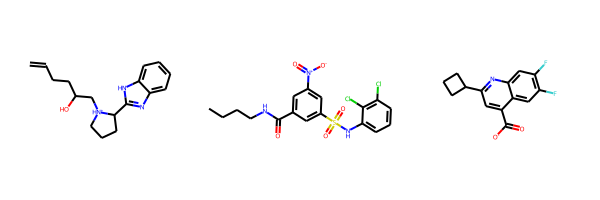

In [18]:
from rdkit.Chem import MolFromSmiles
from rdkit.RDLogger import DisableLog
from rdkit.Chem.Draw import MolsToGridImage
DisableLog("rdApp.*")

valid_molecules = []
for smiles in generated_smiles_list:
    molecule = MolFromSmiles(smiles)
    if molecule is not None:
        valid_molecules.append(molecule)

MolsToGridImage(valid_molecules[:3])

## Further Reading

The pretrained model can be used for transferring knowledge to downstream tasks
including molecular property prediction. Check out
[`smiles_gpt`](https://github.com/sanjaradylov/smiles-gpt/tree/master/smiles_gpt)
repository for implementation details and
[smiles-gpt/scripts](https://github.com/sanjaradylov/smiles-gpt/scripts)
directory for single-/multi-output classification scripts. To evaluate generated
molecules, consider distribution-learning metrics from
[moleculegen-ml](https://github.com/sanjaradylov/moleculegen-ml).

If you find `smiles_gpt` as well as examples from this repository useful in your
research, please consider citing
> Adilov, Sanjar (2021): Generative Pre-Training from Molecules. ChemRxiv. Preprint. https://doi.org/10.33774/chemrxiv-2021-5fwjd